## Comparing over-sampling methods using cross-validation and hyperparameter tuning

[Machine Learning with Imbalanced Data - Course](https://www.trainindata.com/p/machine-learning-with-imbalanced-data)

When we train a classifier, we want it to predict an outcome in a real life dataset. Thus, it is important to evaluate the performance of the classifier on a data set with the original distribution of classes, and not on the rebalanced data.

This means, that the over-sampling methods should be performed on the dataset that we are going to use to train the classifier. But, **the performance of the model should be determined on a portion of the data, that was not re-sampled**.

In this notebook, we will use the imbalanced-learn pipeline, to set up various over-sampling solutions in a way that we train the model on re-sampled data, but we evaluate performance on non-resampled data.

In addition, we will optimize the hyperparamters of the random forests, so we ensure we have the best possible model, trained on each dataset.

In [1]:
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from imblearn.datasets import fetch_datasets
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import (
    RandomOverSampler,
    SMOTE,
    ADASYN,
    BorderlineSMOTE,
    SVMSMOTE,
)

In [2]:
oversampler_dict = {

    'random': RandomOverSampler(
        sampling_strategy='auto',
        random_state=0),

    'smote': SMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        ),

    'adasyn': ADASYN(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        n_neighbors=5,
        ),

    'border1': BorderlineSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-1',
        ),

    'border2': BorderlineSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        kind='borderline-2',
        ),

    'svm': SVMSMOTE(
        sampling_strategy='auto',  # samples only the minority class
        random_state=0,  # for reproducibility
        k_neighbors=5,
        m_neighbors=10,
        svm_estimator=SVC(kernel='linear')),
}

In [3]:
datasets_ls = [
    'ecoli',
    'optical_digits',
    'satimage',
    'pen_digits',
    'abalone',
    'sick_euthyroid',
    'spectrometer',
    'car_eval_34',
    'isolet',
    'us_crime',
    'yeast_ml8',
    'scene',
    'libras_move',
    'thyroid_sick',
    'coil_2000',
    'arrhythmia',
    'solar_flare_m0',
    'oil',
    'car_eval_4',
    'wine_quality',
    'letter_img',
    'yeast_me2',
    'webpage',
    'ozone_level',
    'mammography',
    'protein_homo',
    'abalone_19',
]

len(datasets_ls)

27

In [4]:
# print class imbalance

for dataset in datasets_ls:
    data = fetch_datasets()[dataset]
    print(dataset)
    print(Counter(data.target))
    print()

ecoli
Counter({-1: 301, 1: 35})

optical_digits
Counter({-1: 5066, 1: 554})

satimage
Counter({-1: 5809, 1: 626})

pen_digits
Counter({-1: 9937, 1: 1055})

abalone
Counter({-1: 3786, 1: 391})

sick_euthyroid
Counter({-1: 2870, 1: 293})

spectrometer
Counter({-1: 486, 1: 45})

car_eval_34
Counter({-1: 1594, 1: 134})

isolet
Counter({-1: 7197, 1: 600})

us_crime
Counter({-1: 1844, 1: 150})

yeast_ml8
Counter({-1: 2239, 1: 178})

scene
Counter({-1: 2230, 1: 177})

libras_move
Counter({-1: 336, 1: 24})

thyroid_sick
Counter({-1: 3541, 1: 231})

coil_2000
Counter({-1: 9236, 1: 586})

arrhythmia
Counter({-1: 427, 1: 25})

solar_flare_m0
Counter({-1: 1321, 1: 68})

oil
Counter({-1: 896, 1: 41})

car_eval_4
Counter({-1: 1663, 1: 65})

wine_quality
Counter({-1: 4715, 1: 183})

letter_img
Counter({-1: 19266, 1: 734})

yeast_me2
Counter({-1: 1433, 1: 51})

webpage
Counter({-1: 33799, 1: 981})

ozone_level
Counter({-1: 2463, 1: 73})

mammography
Counter({-1: 10923, 1: 260})

protein_homo
Counter({

In [5]:
# function to train random forests and evaluate the performance
# with hyperparameter optimization

def run_model(X_train, y_train, oversampler=None):

    # set up the classifier
    rf = RandomForestClassifier(
        n_estimators=100, random_state=39, max_depth=3,
    )

    # set up a scaler
    # (as the oversampling techniques use KNN
    # we put the variables in the same scale)
    scaler = MinMaxScaler()

    # without sampling:
    if not oversampler:

        model = rf

        rf_params = {
            "n_estimators": [10, 50, 100, 500],
            "max_depth": [1, 2, 3, 4],
        }

    # set up a pipeline with sampling:
    else:

        # important to scale before the re-sampler
        # as the many of methods require the variables in
        # a similar scale
        model = Pipeline([
            ("scaler", scaler),
            ("sampler", oversampler),
            ("model", rf),
        ])

        rf_params = {
            "model__n_estimators": [10, 50, 100, 500],
            "model__max_depth": [1, 2, 3, 4],
        }

    # When we make a pipeline and then run the training of the model
    # with cross-validation, the procedure works as follows:

    # 1) take 2 of the 3 fold as train set
    # 2) resample the 2 fold (aka, the train set)
    # 3) train the model on the resampled data from point 2
    # 4) evaluate performance on the 3rd fold, that was not resampled

    # this way, we make sure that we are not evaluating the performance
    # of our classifier on the over-sampled data

    search = RandomizedSearchCV(
        model,
        rf_params,
        random_state=0,
        scoring="roc_auc",
    )

    search.fit(X_train, y_train)

    print('Best parameters: {0}, \n Best score: {1}'.format(
        search.best_params_, search.best_score_))

    return search

In [6]:
# now we train several models, with the different over-samplers and
# with cross-validation for each dataset

# to store the results
mean_dict = {}
std_dict = {}


for dataset in datasets_ls:

    # initiate a dictionary per dataset
    mean_dict[dataset] = {}
    std_dict[dataset] = {}

    print(dataset)

    # load dataset
    data = fetch_datasets()[dataset]

    # separate dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split(
        data.data,
        data.target,
        test_size=0.3,
        random_state=0,
    )

    # train model on data without re-sampling
    # with cross-validation
    search = run_model(X_train, y_train)

    m, s = pd.DataFrame(search.cv_results_).sort_values(
        by="mean_test_score",
        ascending=False).loc[0, ["mean_test_score", "std_test_score"]].values

    # store results
    mean_dict[dataset]['full_data'] = m
    std_dict[dataset]['full_data'] = s

    print()

    for oversampler in oversampler_dict.keys():

        print(oversampler)

        # resample, train and evaluate performance
        # with cross-validation
        search = run_model(X_train, y_train, oversampler_dict[oversampler])

        m, s = pd.DataFrame(search.cv_results_).sort_values(
            by="mean_test_score",
            ascending=False).loc[0, ["mean_test_score", "std_test_score"]].values

        # store results
        mean_dict[dataset][oversampler] = m
        std_dict[dataset][oversampler] = s
        print()

    print()

ecoli
Best parameters: {'n_estimators': 50, 'max_depth': 4}, 
 Best score: 0.9220905923344948

random
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 4}, 
 Best score: 0.9079210220673636

smote
Best parameters: {'model__n_estimators': 500, 'model__max_depth': 2}, 
 Best score: 0.9183739837398374

adasyn
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 4}, 
 Best score: 0.9283042973286875

border1
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 4}, 
 Best score: 0.919047619047619

border2
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.9217653890824622

svm
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 4}, 
 Best score: 0.927177700348432


optical_digits
Best parameters: {'n_estimators': 100, 'max_depth': 4}, 
 Best score: 0.9826629268046189

random
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.9831074940647534

smote
Best parameters: {'model

Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.6315947267241923


scene
Best parameters: {'n_estimators': 100, 'max_depth': 4}, 
 Best score: 0.7835855089247501

random
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 4}, 
 Best score: 0.8176015206062285

smote
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 4}, 
 Best score: 0.8010737393318396

adasyn
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 3}, 
 Best score: 0.8037222124317112

border1
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.8062208907127213

border2
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 4}, 
 Best score: 0.8064927871906548

svm
Best parameters: {'model__n_estimators': 50, 'model__max_depth': 4}, 
 Best score: 0.8052881347398102


libras_move
Best parameters: {'n_estimators': 100, 'max_depth': 4}, 
 Best score: 0.9284574468085107

random
Best parameters: {'model__n_es

Best parameters: {'model__n_estimators': 500, 'model__max_depth': 2}, 
 Best score: 0.9023511306532666

svm
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.9038304917444364


webpage
Best parameters: {'n_estimators': 500, 'max_depth': 2}, 
 Best score: 0.9283516239172688

random
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.9271562671830562

smote
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.8399707875661571

adasyn
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.8226862573048448

border1
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.8211198821691397

border2
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.8692758015486133

svm
Best parameters: {'model__n_estimators': 100, 'model__max_depth': 4}, 
 Best score: 0.8473357920024027


ozone_level
Best paramet

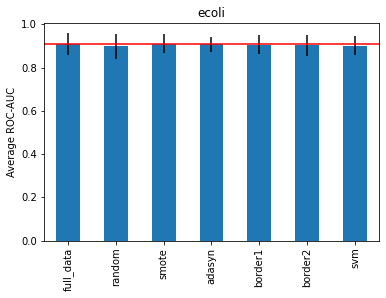

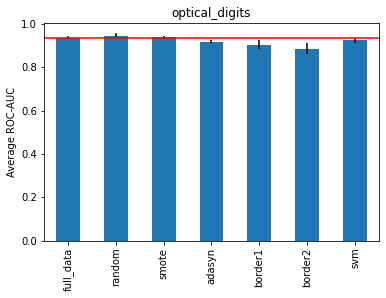

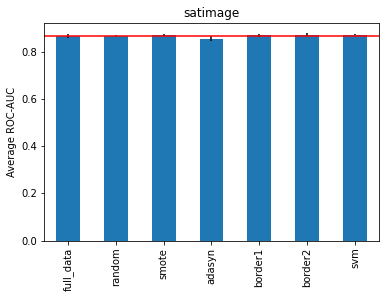

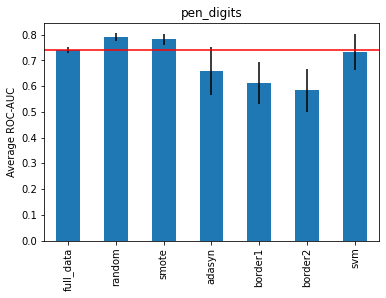

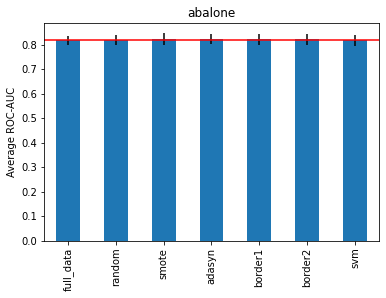

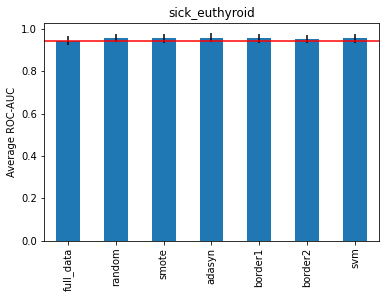

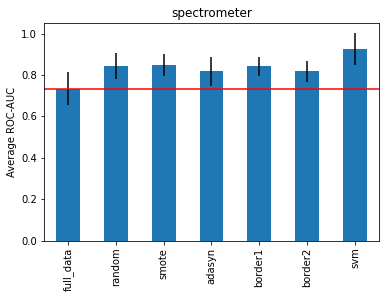

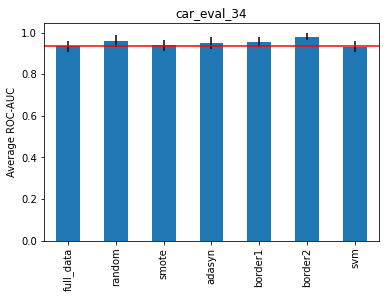

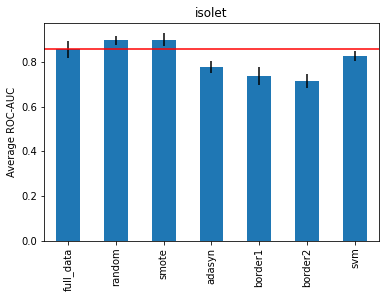

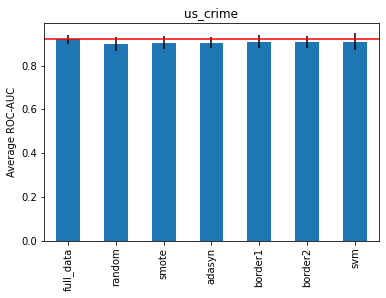

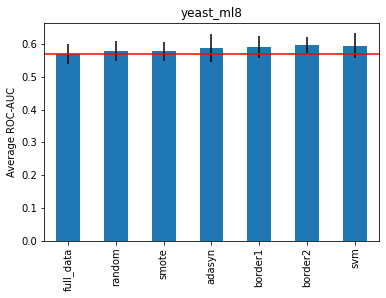

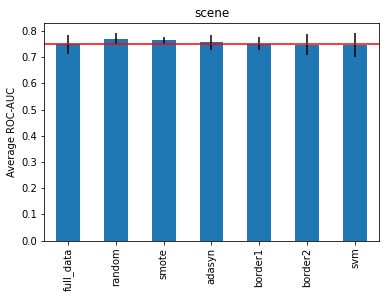

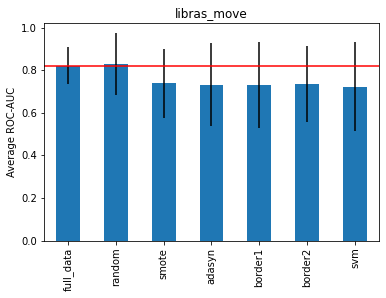

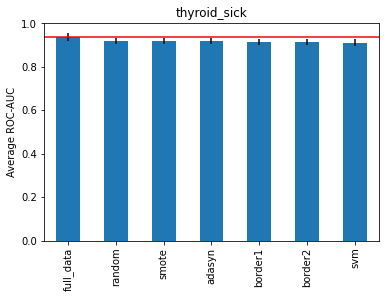

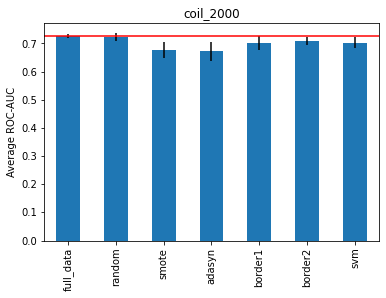

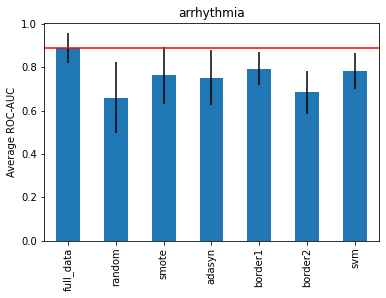

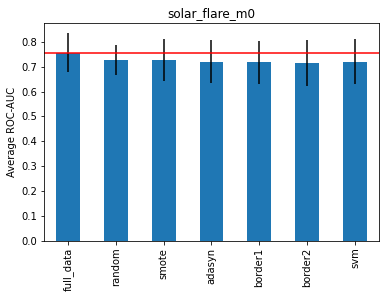

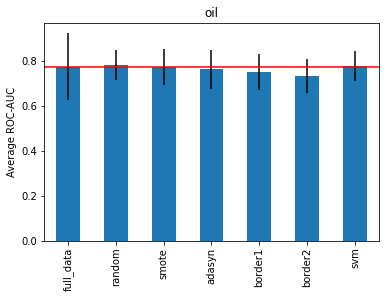

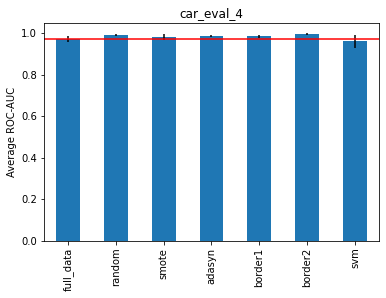

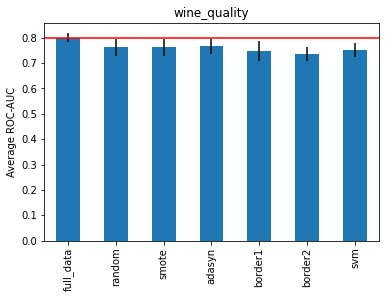

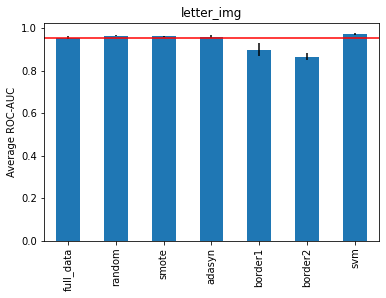

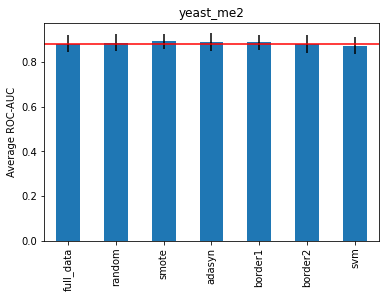

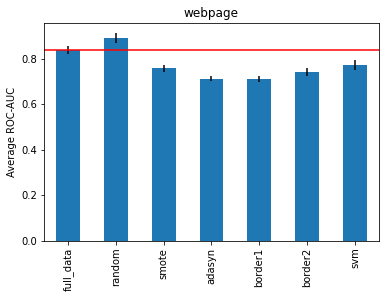

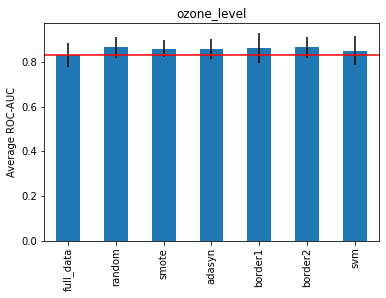

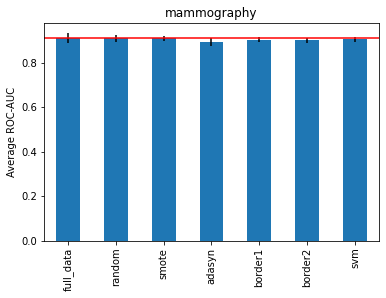

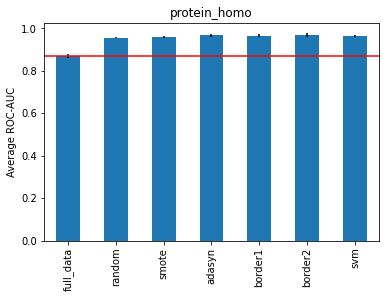

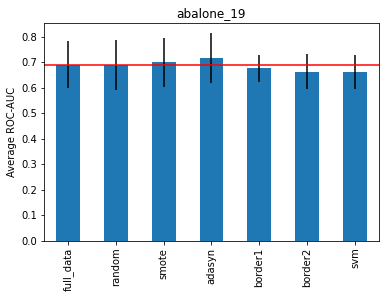

In [7]:
# Now we plot the performance of the model in the 
# left out fold, that was not resampled, from the X_train

for dataset in datasets_ls:
    
    mean_s = pd.Series(mean_dict[dataset])
    std_s = pd.Series(std_dict[dataset])
    
    mean_s.plot.bar(yerr=[std_s, std_s]
        )
    plt.title(dataset)
    plt.ylabel('Average ROC-AUC')
    plt.axhline(mean_dict[dataset]['full_data'], color='r')
    plt.show()

In most datasets, over-sampling methods did not improve the performance of random forests respect to the roc-auc.

- In `pen-digits` random over-sampling increased the value of the roc-auc, smote also a little.

- In the `spectrometer` dataset SVM SMOTE increased the value of the roc-auc significantly. All other methods increased the value as well, although not significantly.

- In the `car_eval_32` borderline SMOTE variant 2 seem to have increased the roc-auc significantly.

- In the `webpage` dataset, random oversampling increased the value of the roc-auc.

- In the `protein homo` dataset, all methods improved the performance substantially.

Of course, this is not the end of the story. Here we are just comparing one performance metric. In a serious study we'd continue analsying the model outputs to understand which samples they classify correctly and which ones they don't, which are the important features, what types of synthetic samples where generated and do they make sense, and also how uncalibrated are the probabilities and can we live with that.



In [11]:
import pickle 

with open('os_mean.pkl', 'wb') as f:
    pickle.dump(mean_dict, f)

with open('os_std.pkl', 'wb') as f:
    pickle.dump(std_dict, f)

In [12]:
with open('os_mean.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

loaded_dict

{'ecoli': {'full_data': 0.9069570267131242,
  'random': 0.8975842044134728,
  'smote': 0.910418118466899,
  'adasyn': 0.9072706155632986,
  'border1': 0.9059930313588851,
  'border2': 0.9032171893147503,
  'svm': 0.9005574912891987},
 'optical_digits': {'full_data': 0.9373650668806933,
  'random': 0.9458656379965305,
  'smote': 0.9394934942620796,
  'adasyn': 0.9174283954599426,
  'border1': 0.9045436656030142,
  'border2': 0.8864834578358686,
  'svm': 0.9257188459470524},
 'satimage': {'full_data': 0.8655739236013822,
  'random': 0.8689878064452248,
  'smote': 0.8695933410157503,
  'adasyn': 0.8561842579269692,
  'border1': 0.8695800512769736,
  'border2': 0.8725612539333765,
  'svm': 0.8732682259023855},
 'pen_digits': {'full_data': 0.7412598362186562,
  'random': 0.789425125634967,
  'smote': 0.7815426575069178,
  'adasyn': 0.6582206146503871,
  'border1': 0.6117449621699215,
  'border2': 0.584554751115836,
  'svm': 0.7339649351097125},
 'abalone': {'full_data': 0.8182979396420895,
